In [1]:
import pandas as pd
from typing import List
import glob
import pathlib
import re
import matplotlib as mpl

import matplotlib.pyplot as plt

#matplotlib.use('TkAgg')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

ROW_TEMPLATE = {
    'dataset': None, 
    'overlap': None, 
    'algorithm': None, 
    'selection_metric': None, 
    'evaluation_metric': None,
    'selection_value': None,
    'evaluation_value': None,
    'selection_std': None,
    'evaluation_std': None,
    }
VIABLE_SELECTION_METRICS = ['acc', 'f1', 'oacc', 'nacc']
VIABLE_EVALUATION_METRICS = ['acc', 'f1', 'oacc', 'nacc']

In [2]:
# get latex files
latex_files = glob.glob('/Users/kimathikaai/scratch/saved/domainbed_results/**/*.tex', recursive=True)
assert not len(latex_files) % 16

### Playground for regex based string processing

In [3]:
# Playground for regex based string processing
txt = "\textbf{Algorithm}        & \textbf{VLCS}             & \textbf{OfficeHome}       & \textbf{Avg}              \\"
print(re.split("\s+", txt.replace("\textbf", ""
        ).replace("&", ""
        ).replace("{", ""
        ).replace("}", ""
        ).replace("\\", "").strip()))
print(re.split(
    "\s+", 
    re.sub(r"\textbf{(\w+)}", r"\1", 
           txt.replace("&", "").replace("\\", "")).strip()))

txt = "ERM                       & 75.6 $\pm$ 0.4            & 59.8 $\pm$ 0.7            & 67.7                      \\"
re.split(
    "\s+",
    txt.replace("$\pm$ ", "").replace("&", "").replace("\\", "").strip()
    )

['Algorithm', 'VLCS', 'OfficeHome', 'Avg']
['Algorithm', 'VLCS', 'OfficeHome', 'Avg']


['ERM', '75.6', '0.4', '59.8', '0.7', '67.7']

### Convert latex documents to a Pandas DataFrame

In [4]:
from IPython.core.debugger import set_trace
# file scraping function that returns a row
    # Inputs: file_path
    # Returns: row as defined by ROW_TEMPLATE (perform check in function)
def scrape_latex(latex_file_path) -> List[dict]:
    
    rows = []
        
    def get_header(line):
        header = re.split(
            "\s+", 
            re.sub(r"\\textbf{(\w+)}", r"\1", line.replace("&", "").replace(r"\\", "")).strip()
            )
        dataset_list = header[1: -1]
        return header, dataset_list

    # get selection and evaluation metric
    file_name = pathlib.Path(latex_file_path).stem
    selection_metric = file_name.split('_')[-2]
    evaluation_metric = file_name.split('_')[-1]
    overlap = file_name.split('_')[-3]
    
    #print(file_name, selection_metric, evaluation_metric, overlap)
    assert selection_metric in VIABLE_SELECTION_METRICS
    assert evaluation_metric in VIABLE_EVALUATION_METRICS
    
    # read file contents
    with open(latex_file_path, 'r') as f:
        found_section = False
        found_table = False
        found_header = False
        found_table_start = False
            
        lines = f.readlines()
        for row_n, line in enumerate(lines):
            
            # print(row_n,line)
            # get to training-domain model selection section
            if (re.search("subsection{Model.*training-domain", line) or found_section):
                #if not found_section: print("*"*10, line)
                found_section = True
                if (re.search("subsubsection{Averages}", line) or found_table):
                    #if not found_table: print("*"*10, line)
                    found_table = True
                    if (re.search("textbf{Algorithm}", line) or found_header):
                        if not found_header:
                            # therefore first time to find header
                            # get header items
                            header, dataset_list = get_header(line)
                            #print(header)
                            #print(dataset_list)
                            
                            found_header = True
                            
                        # look for table beginning
                        if ('midrule' in line or found_table_start):
                            if not found_table_start:
                                found_table_start = True
                                continue
                            
                            # don't process after /bottom/rule
                            if ('bottomrule' in line):
                                # finished reading table
                                break
                            
                            # strip the row for each algorithm for
                            # value and std per dataset
                            algo_row = re.split(
                                "\s+",
                                line.replace("$\\pm$ ", ""
                                    ).replace("&", ""
                                    ).replace(r"\\", ""
                                    ).strip()
                                )
                            algorithm = algo_row.pop(0)
                            average = algo_row.pop()
                            values = algo_row
                            #print("*"*10, algo_row)
                            
                            # Support 'X'
                            org_values = values[:]
                            values = []
                            for item in org_values:
                                if item == "X":
                                    values.extend(["X", "X"])
                                else:
                                    values.append(item)

                            for idx, dataset in enumerate(dataset_list):
                                if values[idx*2] == 'X': continue
                                if float(values[idx*2]) < 0: continue
                                algorithm = "POXL" if algorithm == "XDomError" else algorithm
                                algorithm = "POXL-F" if algorithm == "XDom" else algorithm
                                algorithm = "POXL-F+B" if algorithm == "XDomBeta" else algorithm
                                try:
                                    row = {
                                        'dataset': dataset, 
                                        'overlap': overlap, 
                                        'algorithm': algorithm, 
                                        'selection_metric': selection_metric, 
                                        'evaluation_metric': evaluation_metric,
                                        'selection_value': None,
                                        'evaluation_value': float(values[idx*2]),
                                        'selection_std': None,
                                        'evaluation_std': float(values[idx*2 +1]),
                                    }
                                    rows.append(row)
                                except:
                                    set_trace()
                                    print(values)
    return rows
                        

data = []
# scrape each latex file
for file in latex_files:
    print('[info] processing: ', file)
    data.extend(scrape_latex(file))

# convert to pandas data frame
df = pd.DataFrame.from_dict(data)

[info] processing:  /Users/kimathikaai/scratch/saved/domainbed_results/66/domainbed_results_All_66_nacc_nacc.tex
[info] processing:  /Users/kimathikaai/scratch/saved/domainbed_results/66/domainbed_results_All_66_oacc_f1.tex
[info] processing:  /Users/kimathikaai/scratch/saved/domainbed_results/66/domainbed_results_All_66_oacc_oacc.tex
[info] processing:  /Users/kimathikaai/scratch/saved/domainbed_results/66/domainbed_results_All_66_acc_nacc.tex
[info] processing:  /Users/kimathikaai/scratch/saved/domainbed_results/66/domainbed_results_All_66_oacc_acc.tex
[info] processing:  /Users/kimathikaai/scratch/saved/domainbed_results/66/domainbed_results_All_66_nacc_f1.tex
[info] processing:  /Users/kimathikaai/scratch/saved/domainbed_results/66/domainbed_results_All_66_f1_f1.tex
[info] processing:  /Users/kimathikaai/scratch/saved/domainbed_results/66/domainbed_results_All_66_acc_f1.tex
[info] processing:  /Users/kimathikaai/scratch/saved/domainbed_results/66/domainbed_results_All_66_f1_oacc.te

### What is  the AVERAGE performance ACROSS DATASETS for each overlap and metric?

In [5]:
df.groupby(['overlap', 'selection_metric', 'evaluation_metric', 'algorithm']).mean()

/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_68125/2889167385.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(['overlap', 'selection_metric', 'evaluation_metric', 'algorithm']).mean()


evaluation_value  \
overlap selection_metric evaluation_metric algorithm                      
33      acc              acc               ARM                45.800000   
                                           CAD                44.433333   
                                           CORAL              47.466667   
                                           ERM                46.400000   
                                           Intra              46.833333   
                                           Intra_XDom         47.500000   
                                           MLDG               45.733333   
                                           POXL               46.666667   
                                           POXL w/o F         47.033333   
                                           POXL-F+B           47.900000   
                                           SelfReg            46.066667   
                                           SupCon             47.900000   
                                           Transfer           45.700000   
                                           XDomBatch          46.100000   
                         f1                ARM                41.266667   
                                           CAD                39.433333   
                                           CORAL              42.700000   
                                           ERM                41.466667   
                                           Intra              42.133333   
                                           Intra_XDom         41.800000   
                                           MLDG               41.566667   
                                           POXL               42.066667   
                                           POXL w/o F         42.933333   
                                           POXL-F+B           43.250000   
                                           SelfReg            41.166667   
                                           SupCon             43.350000   
                                           Transfer           41.133333   
                                           XDomBatch          39.900000   
                         nacc              ARM                38.233333   
                                           CAD                37.833333   
                                           CORAL              39.366667   
                                           ERM                38.800000   
                                           Intra              39.433333   
                                           Intra_XDom         34.900000   
                                           MLDG               40.766667   
                                           POXL               39.433333   
                                           POXL w/o F         39.633333   
                                           POXL-F+B           37.400000   
                                           SelfReg            37.566667   
                                           SupCon             37.700000   
                                           Transfer           39.900000   
                                           XDomBatch          33.600000   
                         oacc              ARM                65.800000   
                                           CAD                62.466667   
                                           CORAL              67.533333   
                                           ERM                66.466667   
                                           Intra              66.633333   
                                           Intra_XDom         86.900000   
                                           MLDG               63.200000   
                                           POXL               66.200000   
                                           POXL w/o F         67.033333   
                                           POXL-F+B           73.150000   
     

### On average what is the best selection metric for an evaluation metric?

In [6]:
df.loc[
    #(df['dataset'] == 'PACS')
#     (df['overlap'] == '33') &
     #((df['evaluation_metric'] == 'nacc') | (df['evaluation_metric'] == 'acc')) &
    (df['evaluation_metric'] == 'nacc') &
    ((df['selection_metric'] == 'nacc') | (df['selection_metric'] == 'f1'))
].groupby(['dataset','overlap', 'selection_metric', 'evaluation_metric']).mean()

/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_68125/2167025168.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.loc[


evaluation_value  \
dataset    overlap selection_metric evaluation_metric                     
OfficeHome 33      f1               nacc                      39.416667   
                   nacc             nacc                      39.583333   
           66      f1               nacc                      38.270000   
                   nacc             nacc                      38.780000   
PACS       33      f1               nacc                      34.242857   
                   nacc             nacc                      35.385714   
           66      f1               nacc                      13.064286   
                   nacc             nacc                      15.614286   
           high    f1               nacc                      56.950000   
                   nacc             nacc                      57.800000   
           low     f1               nacc                      43.500000   
                   nacc             nacc                      45.650000   
           mid     f1               nacc                      39.262500   
                   nacc             nacc                      41.487500   
VLCS       33      f1               nacc                      46.410000   
                   nacc             nacc                      47.830000   
           66      f1               nacc                      36.910000   
                   nacc             nacc                      49.640000   

                                                       evaluation_std  
dataset    overlap selection_metric evaluation_metric                  
OfficeHome 33      f1               nacc                     0.458333  
                   nacc             nacc                     0.400000  
           66      f1               nacc                     0.510000  
                   nacc             nacc                     0.550000  
PACS       33      f1               nacc                     0.864286  
                   nacc             nacc                     0.828571  
           66      f1               nacc                     0.885714  
                   nacc             nacc                     1.421429  
           high    f1               nacc                     0.500000  
                   nacc             nacc                     0.950000  
           low     f1               nacc                     1.100000  
                   nacc             nacc                     0.600000  
           mid     f1               nacc                     0.825000  
                   nacc             nacc                     0.900000  
VLCS       33      f1               nacc                     0.710000  
                   nacc             nacc                     1.020000  
           66      f1               nacc                     1.990000  
                   nacc             nacc                     2.850000

### What is the performance across dataset, overlap and metric?

In [7]:
df.loc[
    (df['dataset'] == 'PACS') &
    (df['overlap'] == '33') &
    (df['evaluation_metric'] == 'nacc') &
    (df['selection_metric'] == 'nacc')
].groupby(['dataset','overlap', 'selection_metric', 'evaluation_metric', 'algorithm']).mean()

/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_68125/1772077876.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.loc[


evaluation_value  \
dataset overlap selection_metric evaluation_metric algorithm                      
PACS    33      nacc             nacc              ARM                     36.8   
                                                   CAD                     33.0   
                                                   CORAL                   33.3   
                                                   ERM                     36.5   
                                                   Intra                   35.8   
                                                   Intra_XDom              37.6   
                                                   MLDG                    38.0   
                                                   POXL                    35.2   
                                                   POXL w/o F              33.2   
                                                   POXL-F+B                35.3   
                                                   SelfReg                 32.4   
                                                   SupCon                  35.4   
                                                   Transfer                36.4   
                                                   XDomBatch               36.5   

                                                               evaluation_std  
dataset overlap selection_metric evaluation_metric algorithm                   
PACS    33      nacc             nacc              ARM                    1.3  
                                                   CAD                    0.9  
                                                   CORAL                  0.8  
                                                   ERM                    0.5  
                                                   Intra                  1.1  
                                                   Intra_XDom             1.6  
                                                   MLDG                   0.1  
                                                   POXL                   0.3  
                                                   POXL w/o F             0.5  
                                                   POXL-F+B               0.5  
                                                   SelfReg                0.4  
                                                   SupCon                 1.2  
                                                   Transfer               1.8  
                                                   XDomBatch              0.6

### What is the difference between "oacc" and "noacc"?

In [8]:
cols = ['dataset', 'overlap', 'selection_metric', 'evaluation_metric', 'algorithm']

# nacc DNE in full overlap and oacc DNE in none overlap
data = df.loc[(
    (df['overlap'] == '33') | (df['overlap'] == '66') | 
    (df['overlap'] == 'mid') | (df['overlap'] == 'low')
)]

cols_a = ['dataset', 'algorithm', 'overlap', 'selection_metric', 'evaluation_value']
df_oacc = data[data['evaluation_metric'] == 'oacc'][cols_a].sort_values(
    by=cols_a, ascending=True).reset_index(drop=True)
df_nacc = data[data['evaluation_metric'] == 'nacc'][cols_a].sort_values(
    by=cols_a, ascending=True).reset_index(drop=True)

assert len(df_nacc) == len(df_oacc)
df_oacc['oacc-nacc'] = df_oacc['evaluation_value'] - df_nacc['evaluation_value']
data = df_oacc[['dataset', 'algorithm', 'overlap', 'selection_metric', 'oacc-nacc']]
a = data.groupby(['dataset', 'overlap', 'selection_metric','algorithm', 'oacc-nacc']).mean()

### What is the top performing algorithm for each dataset, overlap, and metric?
- For OfficeHome (33&66) the non-overlapping accuracy is highest for (XDom, Intra and SupCon approaches) consistently
- In general XDom shines the most with the availability of overlapping classes to benefit the non-overlapping classes (having a memory queue for under represented samples would help)
    - However we can also reduce the scope of the problem by focusing on 50%-75% overlap cases and/or performing random class selection
- (PACS 66) (selec, eval)
    - (acc,acc) XDom, XDomBatch, XDomError
    - (acc,f1) XDom, XDomError, XDomBatch
    - (acc,nacc) Transfer with 0.2% difference from XDomError with 0.7% difference from XDom

In [9]:
cols = ['dataset', 'overlap', 'selection_metric', 'evaluation_metric', 'algorithm']
base_group = df.loc[
#         (df['algorithm'] != 'XDom') &
#         (df['algorithm'] != 'Intra') &
#         (df['algorithm'] != 'SupCon') &
#         (df['algorithm'] != 'Intra_XDom') &
#         ((df['dataset'] == 'PACS') | (df['dataset'] == 'OfficeHome'))  &
#         (df['overlap'] == 66) &
        (df['algorithm'] != 'XDomBatch')
    ].groupby(cols)
base_group.mean().loc[
    base_group.mean().groupby(cols[:-1])['evaluation_value'].idxmax()
]

/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_68125/3777563572.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  base_group.mean().loc[
/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_68125/3777563572.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  base_group.mean().groupby(cols[:-1])['evaluation_value'].idxmax()


evaluation_value  \
dataset    overlap selection_metric evaluation_metric algorithm                      
OfficeHome 33      acc              acc               CORAL                   50.1   
                                    f1                CORAL                   46.7   
                                    nacc              SupCon                  41.7   
                                    oacc              CORAL                   61.7   
                   f1               acc               CORAL                   50.3   
                                    f1                CORAL                   46.6   
                                    nacc              Intra                   41.2   
                                    oacc              CORAL                   62.0   
                   nacc             acc               CORAL                   49.9   
                                    f1                CORAL                   46.2   
                                    nacc              POXL w/o F              41.0   
                                    oacc              CORAL                   61.5   
                   oacc             acc               CORAL                   50.1   
                                    f1                CORAL                   46.4   
                                    nacc              Intra                   40.7   
                                    oacc              CORAL                   61.8   
           66      acc              acc               POXL w/o F              53.7   
                                    f1                POXL w/o F              49.9   
                                    nacc              POXL w/o F              40.8   
                                    oacc              CORAL                   60.7   
                   f1               acc               POXL w/o F              54.0   
                                    f1                POXL w/o F              50.4   
                                    nacc              POXL w/o F              41.3   
                                    oacc              CORAL                   60.5   
                   nacc             acc               POXL w/o F              53.8   
                                    f1                POXL w/o F              50.3   
                                    nacc              POXL w/o F              41.7   
                                    oacc              CORAL                   60.4   
                   oacc             acc               CORAL                   54.0   
                                    f1                CORAL                   49.7   
                                    nacc              POXL                    40.1   
                                    oacc              CORAL                   61.2   
PACS       33      acc              acc               ERM                     47.5   
                                    f1                MLDG                    42.2   
                                    nacc              MLDG                    36.4   
                                    oacc              CORAL                   87.3   
                   f1               acc               ERM                     47.6   
                                    f1                MLDG                    42.7   
                                    nacc              MLDG                    36.6   
                                    oacc              Intra                   87.9   
                   nacc             acc               Intra_XDom              48.7   
                                    f1                Intra_XDom              43.9   
                                    nacc              MLDG                    38.0   
                                    oacc              CORAL                   85.0   
                   oacc             acc               CORAL                   46.9   
                        

In [10]:
import numpy as np
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import MaxNLocator
import itertools

def plot_results(df, selec_metric, eval_metric, overlap_list, dataset_list):
    
    my_cmap = plt.get_cmap("viridis")
    rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

    fig, ax = plt.subplots(
        nrows = len(dataset_list),
        ncols = len(overlap_list),
        figsize=(10,10),
        #figsize=(8,5),
        sharey=False)
    
    if len(dataset_list) == 1:
        ax = [ax]

    for i, dataset in enumerate(dataset_list):
        for j, overlap in enumerate(overlap_list):
            data = df.loc[
                (df['dataset'] == dataset) &
                (df['selection_metric'] == selec_metric) &
                (df['evaluation_metric'] == eval_metric) &
                (df['overlap'] == overlap)
            ].sort_values(by=['algorithm'], ascending=True)
            
            ax[i][j].bar(
                data.algorithm, 
                data.evaluation_value, 
                color=my_cmap(rescale(data.evaluation_value)),
                width=0.6
            )

            #plot_data = df_group.mean()['evaluation_value']
            #max_algo = plot_data.idxmax()
            #print(plot_data)

            #plot_data.plot(ax=ax[i][j], kind="bar")
            ax[i][j].set_title(f"{dataset}-{overlap}")
            #ax[i][j].set_yticks(np.arange(20,60,5))
            ax[i][j].yaxis.set_minor_locator(AutoMinorLocator(2))
            ax[i][j].get_yaxis().set_major_locator(MaxNLocator(integer=True))
            ax[i][j].set_ylim(
                min(data.evaluation_value) - 3,
                max(data.evaluation_value) + 3)
            #ax[i][j].set_ylim(40, 60)
            ax[i][j].grid(axis="y", which="both")
            ax[i][j].tick_params(axis='x', labelrotation=90)
            # ax[i][j].legend()
    
    fig.suptitle(f"(s,e) = ({selec_metric},{eval_metric})")
    fig.tight_layout(pad=1.0, h_pad=2.0)
    return fig

## Plot Results Across "Datasets" and "Overlaps"
- XDomError performance drop for lower overlaps is worse than XDom
- For selec_methods = 'acc' and 'f1', XDomError 'nacc' is not strongest 

/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_68125/4210815773.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_results(df, s, e, overlap_list, dataset_list).show()
/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_68125/4210815773.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_results(df, s, e, overlap_list, dataset_list).show()
/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_68125/4210815773.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_results(df, s, e, overlap_list, dataset_list).show()
/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_68125/4210815773.py:10: UserWarning: Matplotlib is currently using module://matplotlib_in

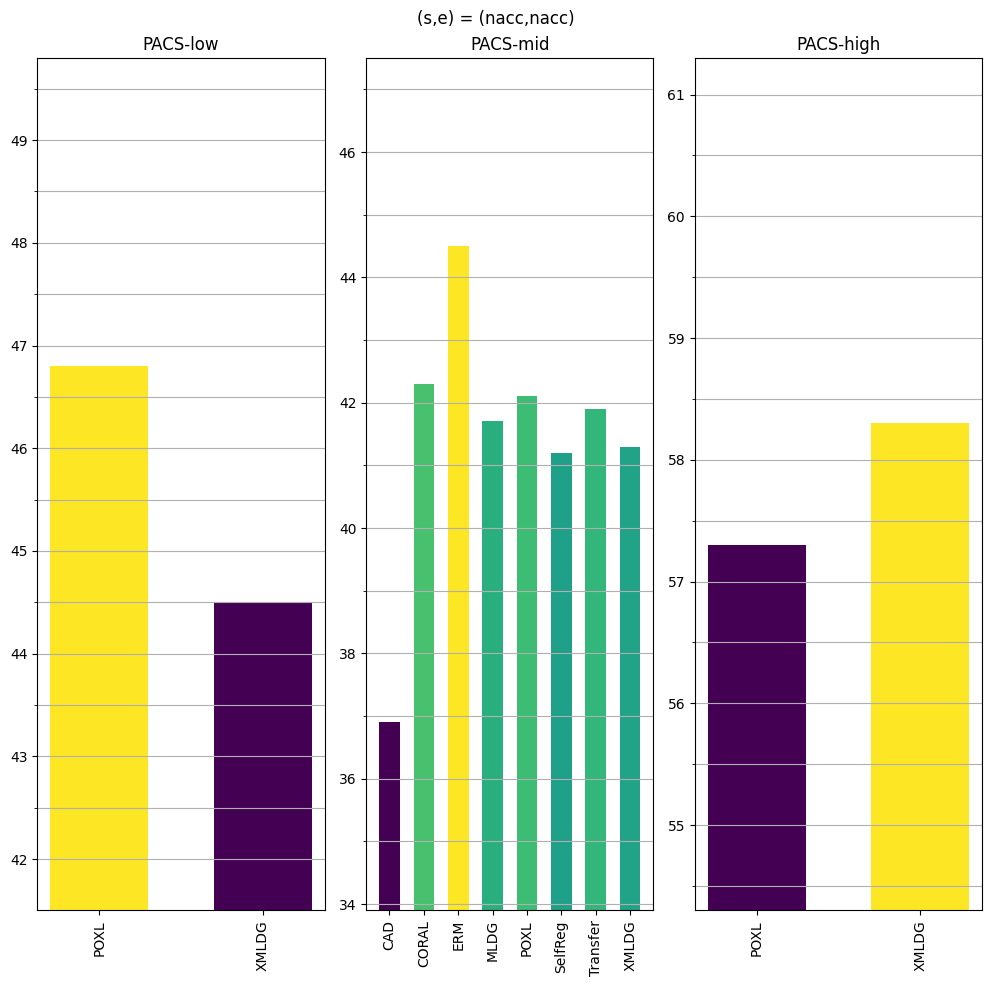

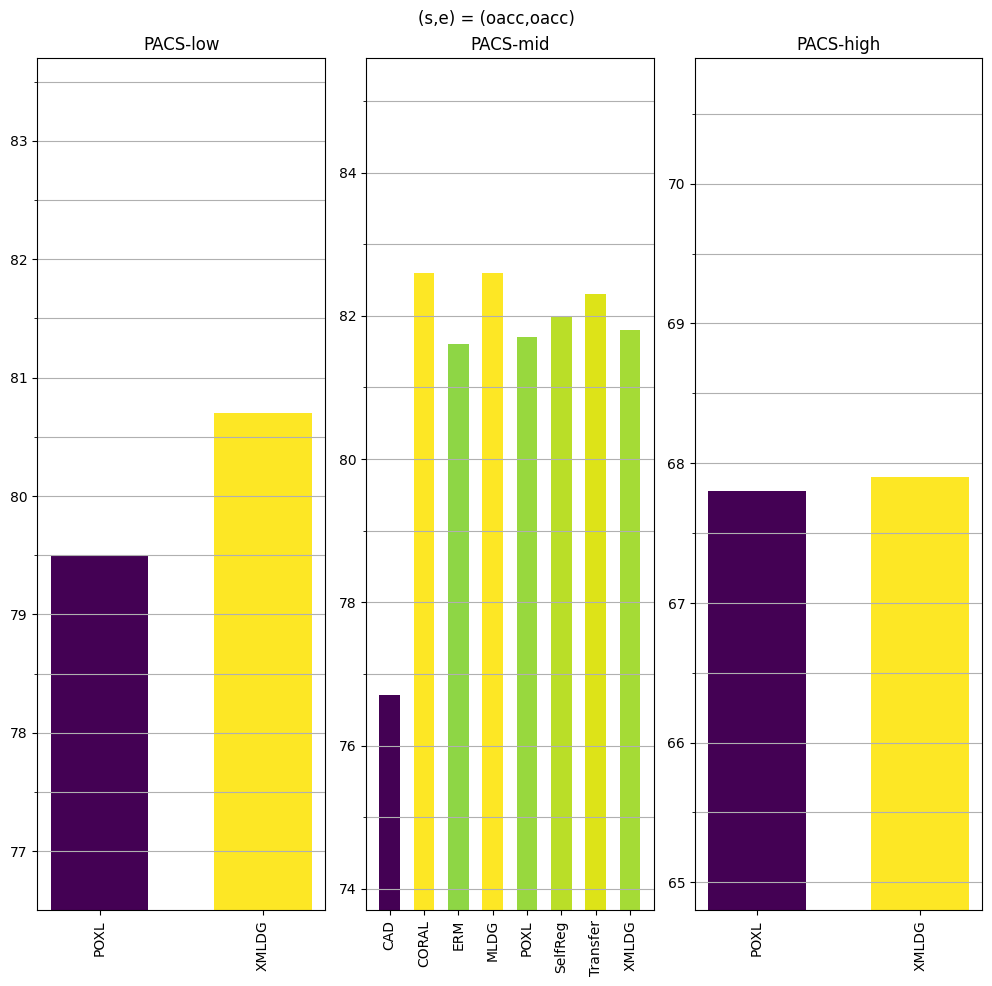

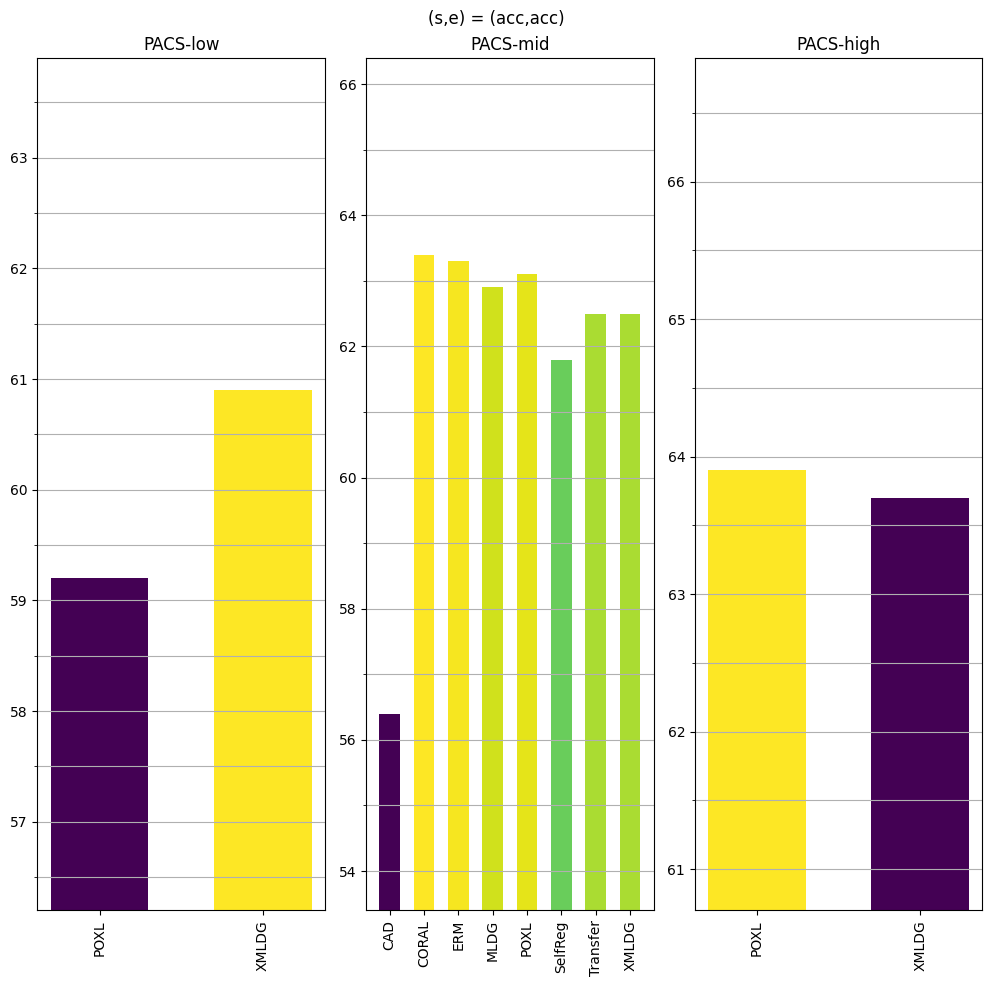

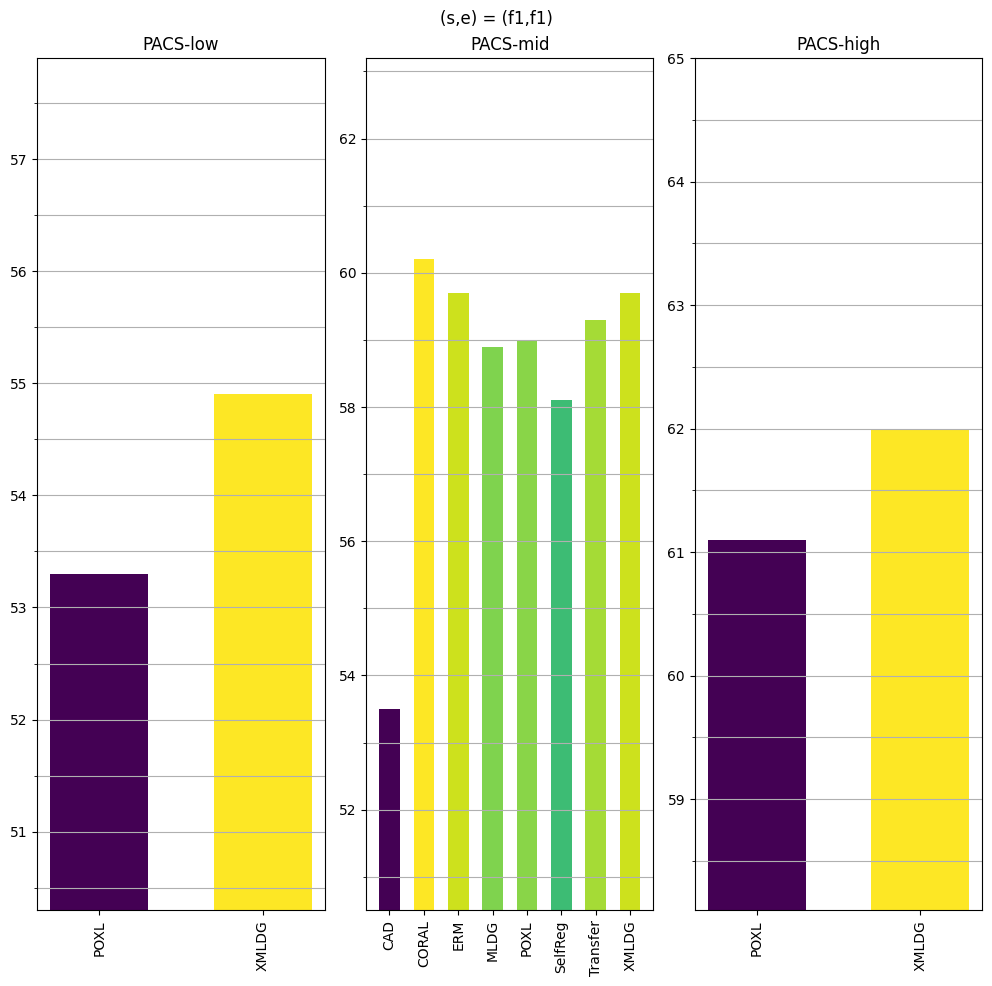

In [11]:
overlap_list = ['low', 'mid', 'high']
dataset_list = list(df["dataset"].unique())
dataset_list = ['PACS']
sl = list(df["selection_metric"].unique())
el = list(df["evaluation_metric"].unique())
sl_el = itertools.product(sl, el)
for s, e in sl_el:
    if e != s: continue
    # if e != 'f1' or s != 'f1': continue
    plot_results(df, s, e, overlap_list, dataset_list).show()

## Plot baselines performance across different overlaps and datasets
- XDomBeta > XDom for PACS (nacc,nacc) & (acc,acc) & (f1,f1)

/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_68125/1621392382.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_results(data, s, e, overlap_list, dataset_list).show()
/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_68125/1621392382.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_results(data, s, e, overlap_list, dataset_list).show()
/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_68125/1621392382.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_results(data, s, e, overlap_list, dataset_list).show()
/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_68125/1621392382.py:19: UserWarning: Matplotlib is currently using module://matplot

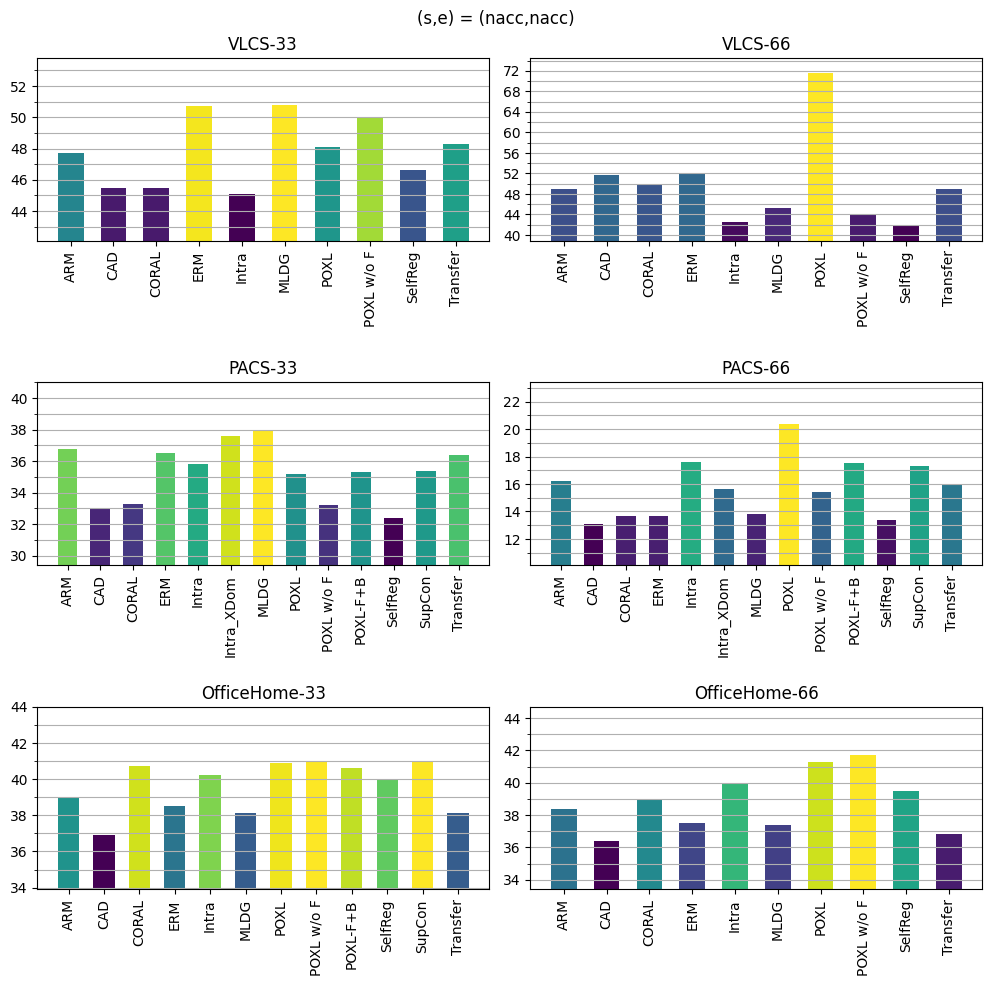

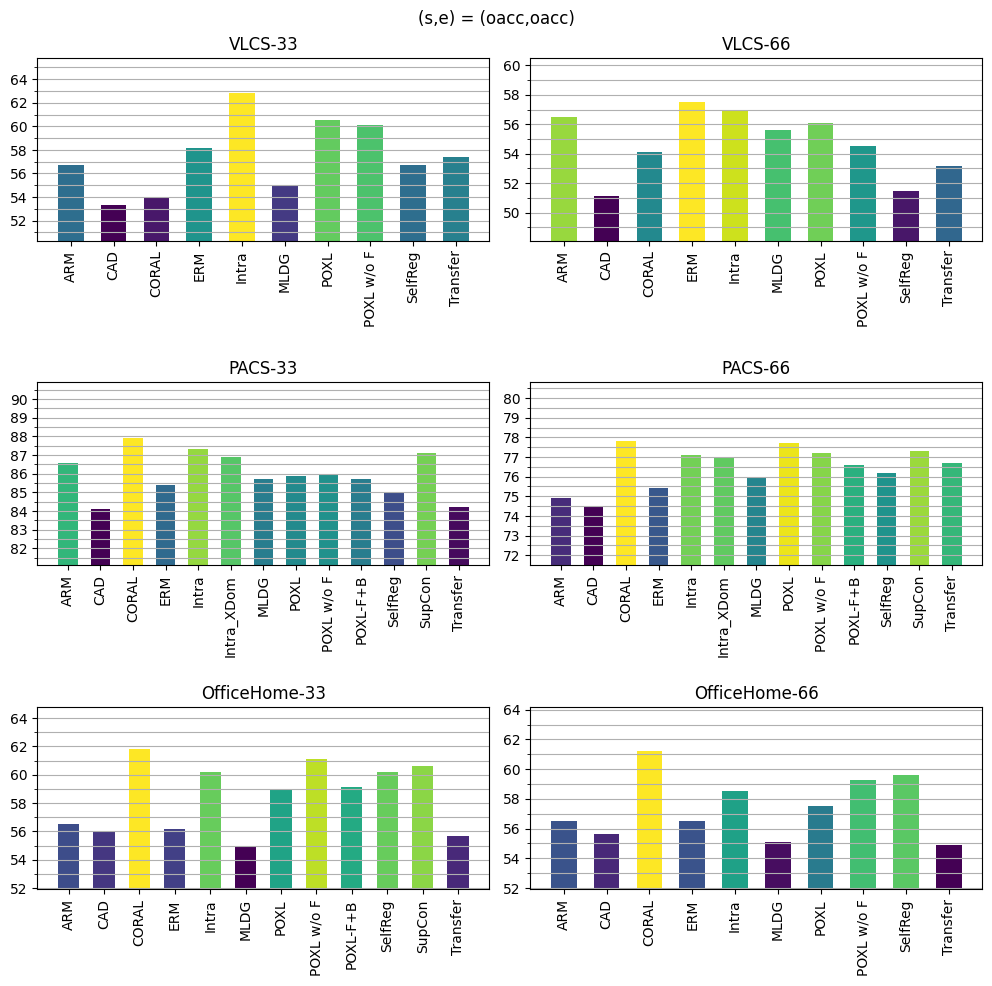

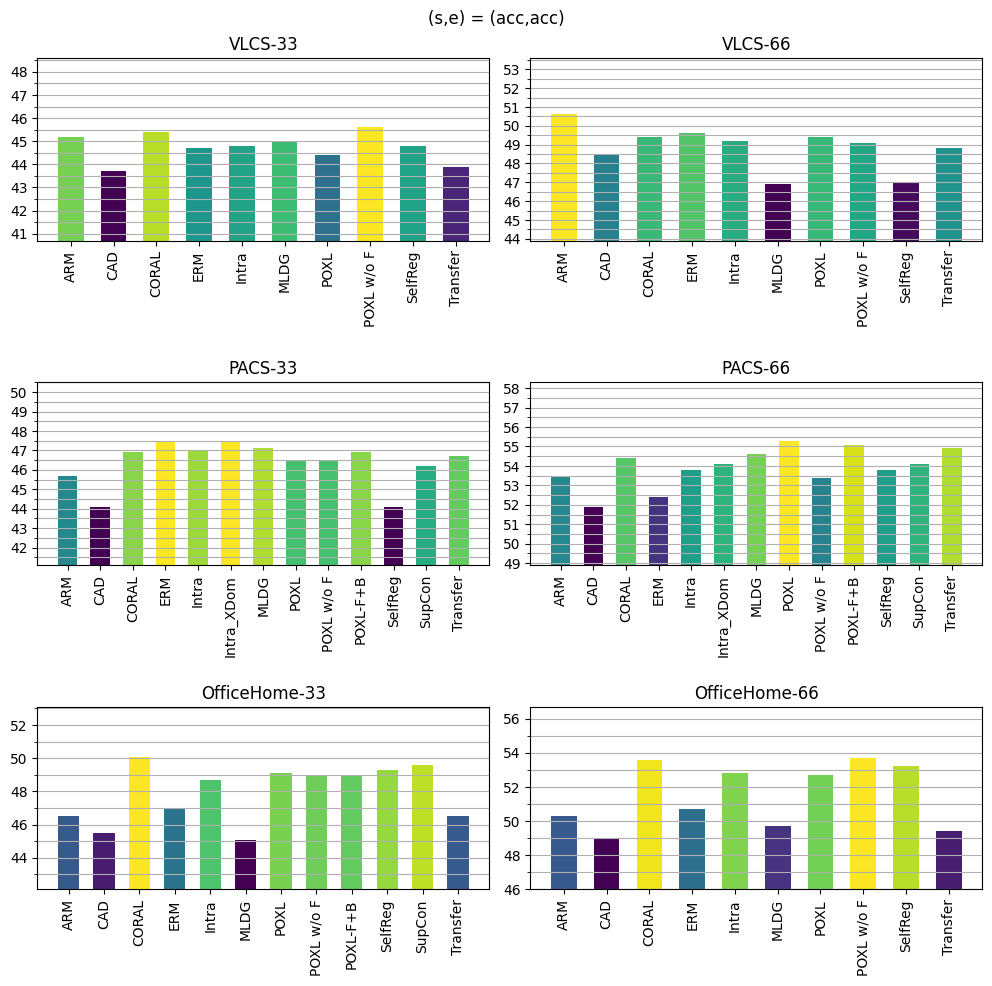

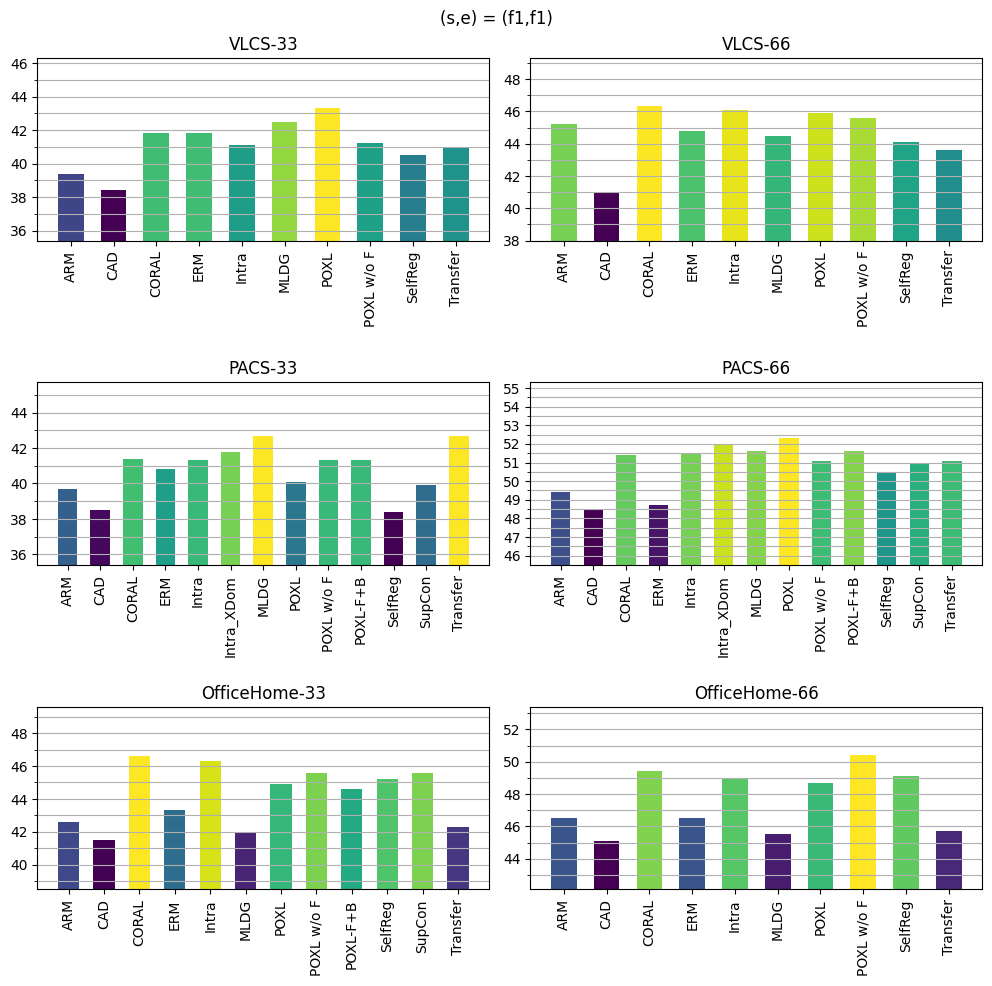

In [12]:
# remove non-baseline
data = df.loc[
#     (df['algorithm'] != 'Intra') &
#     (df['algorithm'] != 'SupCon') &
#     (df['algorithm'] != 'Intra_XDom') &
#     (df['algorithm'] != 'XDom') &
#     (df['algorithm'] != 'XDomError') &
    (df['algorithm'] != 'XDomBatch')
]

overlap_list = ['33', '66']
dataset_list = list(df["dataset"].unique())
sl = list(data["selection_metric"].unique())
el = list(data["evaluation_metric"].unique())
sl_el = itertools.product(sl, el)
for s, e in sl_el:
    if e != s: continue
    # if e != 'f1' or s != 'f1': continue
    plot_results(data, s, e, overlap_list, dataset_list).show()

## Plot the stacked relationship between datasets and all overlaps
- The purpose is to provide a visualization of the the non-overlapping performance across data sets averaged over the different overlap cases

In [14]:
from matplotlib.ticker import AutoMinorLocator
def stack_plot_results(df, selec_metric, eval_metric):
    dataset_list = ['PACS','VLCS','OfficeHome']
    overlap_list = ['33', '66']
    color = ['#024b7a', '#44a5c2']
    
    fig, ax = plt.subplots(
        nrows = 1,
        ncols = len(dataset_list),
        #figsize=(10,10),
        figsize=(10,4),
        sharey=False)
    
    for i, dataset in enumerate(dataset_list):
        data = df.loc[
            (df['dataset'] == dataset) &
            (df['selection_metric'] == selec_metric) &
            (df['evaluation_metric'] == eval_metric) &
            (df['algorithm'] != 'SupCon') &
            #(df['algorithm'] != 'Intra') &
            #(df['algorithm'] != 'Intra_XDom') &
            (df['algorithm'] != 'XDomBatch')
        ].sort_values(by=['algorithm'], ascending=True)
        
        values = []
        for overlap in overlap_list:
            values.append(
                list(data.loc[(df['overlap'] == overlap)]['evaluation_value'])
            )
        values = np.array(values)
        
        # set_trace()
        # stack bar charts
        for j in range(values.shape[0]):
            ax[i].bar(
                x = list(data[data['overlap'] == overlap_list[j]]['algorithm'].unique()),
                height = values[j],
                bottom = np.sum(values[:j], axis=0),
                color=color[j],
                label=overlap_list[j]
            ) 
        ax[i].set_title(dataset)
        ax[i].set_ylabel = selec_metric
        ax[i].tick_params(axis='x', labelrotation=90)
        ax[i].grid(axis="y", which="both")
        ax[i].yaxis.set_minor_locator(AutoMinorLocator(2))
        
        if i == 0:
            handles, labels = ax[i].get_legend_handles_labels()
            fig.legend(
                handles,
                labels, 
                loc="upper center",
                title="Overlap Cases",
                ncols=len(overlap_list),
                bbox_to_anchor=(0.5, .93)
            )
    
    fig.suptitle(f"(s,e) = ({selec_metric},{eval_metric})")
    #fig.legend(loc="upper center", title="Overlap Case", ncols=2)
    fig.tight_layout(pad=3.0, w_pad=1.0)
    return fig

sl = list(df["selection_metric"].unique())
el = list(df["evaluation_metric"].unique())
sl_el = itertools.product(sl, el)
for s, e in sl_el:
    #if e != 'nacc' or s != 'nacc': continue
    #if s != 'nacc': continue
    if s != e: continue
    #stack_plot_results(df=df, selec_metric=s, eval_metric=e).show()

## Plot the relationship between "nacc" and "oacc"
- Could average across: datasets, overlaps, selection_metrics
    - Across datasets would be the most beneficial and easiest to justify
- Purpose of this plot is display the relationship between non-overlapping and overlapping class accuracies for different methods
- With `selec_metric='nacc'` across all datasets (even excluding VLCS anomally) XDom best accuracy and XDomError best non-overlapping accuracy
- Set the ylim and xlim with the zoom in plot to show the performance discrepancy
- Show the accuracy color gradient in the plot
- Use a zoomed in subplot for the results

(nacc, oacc)
    algorithm  evaluation_value  evaluation_std
0         ARM         60.333333        1.100000
1         CAD         57.950000        2.583333
2       CORAL         62.183333        1.116667
3         ERM         60.600000        1.383333
4        MLDG         60.933333        1.183333
5        POXL         57.283333        1.900000
6  POXL w/o F         62.000000        1.116667
7    POXL-F+B         72.100000        1.266667
8     SelfReg         60.566667        1.383333
9    Transfer         59.250000        1.733333
(nacc, nacc)
    algorithm  evaluation_value  evaluation_std
0         ARM         37.850000        1.133333
1         CAD         36.100000        1.916667
2       CORAL         36.983333        1.333333
3         ERM         38.116667        1.266667
4        MLDG         37.216667        1.133333
5        POXL         42.900000        1.450000
6  POXL w/o F         37.550000        0.800000
7    POXL-F+B         31.133333        0.833333
8     SelfReg 

/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_68125/3642724918.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  metric_data = data.groupby('algorithm').mean().reset_index(names="algorithm")
/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_68125/3642724918.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  metric_data = data.groupby('algorithm').mean().reset_index(names="algorithm")
/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_68125/3642724918.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric

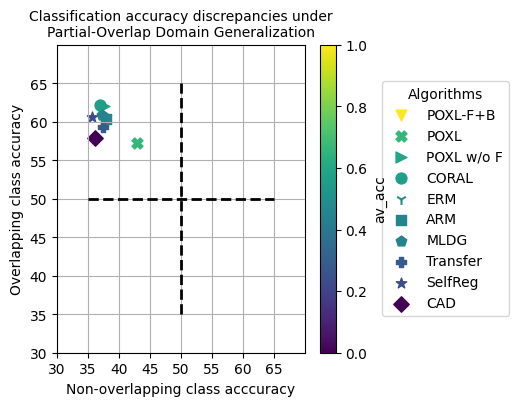

In [15]:
import math
color_metric = "av_acc"

def get_metric(data, eval_metric, selec_metric='nacc'):
    """Averaging across overlaps and datasets"""
    print(f"({selec_metric}, {eval_metric})")
    data = df.loc[
        #(df['dataset'] != 'VLCS') &
        # (df['dataset'] == 'OfficeHome') &
        (df['selection_metric'] == selec_metric) &  
        (df['evaluation_metric'] == eval_metric) &
        ((df['overlap'] == '33') | (df['overlap'] == '66')) &
        (df['algorithm'] != 'XDomBatch') &
#         (df['algorithm'] != 'XDom') &
#         (df['algorithm'] != 'XDomError') &
        (df['algorithm'] != 'SupCon') &
        (df['algorithm'] != 'Intra') &
        (df['algorithm'] != 'Intra_XDom')
    ].sort_values(by='algorithm', ascending=True).reset_index(drop=True)
    
    cols = ['algorithm', 'overlap', 'dataset', 'evaluation_value']
    # print(data.groupby(cols).mean())
    metric_data = data.groupby('algorithm').mean().reset_index(names="algorithm")
    print(metric_data)
    return metric_data


df_oacc = get_metric(df, 'oacc')
df_nacc = get_metric(df, 'nacc')
df_acc = get_metric(df, 'acc')
assert len(df_oacc) == len(df_nacc) == len(df_acc)

# dataframe 
data = pd.DataFrame(data={
    'algorithm': df_oacc['algorithm'],
    'nacc': df_nacc['evaluation_value'],
    'oacc': df_oacc['evaluation_value'],
    'acc': df_acc['evaluation_value'],
    'av_acc': (df_oacc['evaluation_value']+df_nacc['evaluation_value'])/2,
    'f1': get_metric(data, 'f1')['evaluation_value'],
    'diff': df_oacc['evaluation_value'] - df_nacc['evaluation_value'],
})
data = data.sort_values(by=color_metric, ascending=False).reset_index(drop=True)
print(data)
# TODO: scale  nacc and oacc for error line to be drawn
# colour map
my_cmap = plt.get_cmap("viridis")
def rescale(row, rows):
    return (row - np.min(rows)) / (np.max(rows) - np.min(rows))
    
rescale_lmbd = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

# scatter plot
fig, ax = plt.subplots(figsize=(4,4))
markers = ['v','X','>', 'o', '1','s','p', 'P', '*', 'D', 'd']
assert len(markers) >= len(data)
for index, row in data.iterrows():
    s=ax.scatter(
#         x=rescale(row['nacc'], data['nacc']),
#         y=rescale(row['oacc'], data['oacc']),
        x=row['nacc'],
        y=row['oacc'],
        color=my_cmap(rescale(row[color_metric], data[color_metric])),
        label=row['algorithm'],
        marker=markers[index],
        s=mpl.rcParams['lines.markersize'] ** 2.3
    )
    
# ax.scatter(
#     x=data['nacc'],
#     y=data['oacc'],
#     c=rescale_lmbd(data[color_metric]),
#     label=list(data['algorithm']),
#     cmap=my_cmap,
#     s=mpl.rcParams['lines.markersize'] ** 2.3,
#     #markers=markers
# )
# ax.plot([0,1], [0,1], 'k--')
# ax.plot([30,70], [30,70], 'k--', linewidth=1)

# AXIS LABELS
ax.set_title(("Classification accuracy discrepancies under\n"
              "Partial-Overlap Domain Generalization"), 
            fontsize=10)
ax.set_xlabel("Non-overlapping class acccuracy")
ax.set_ylabel("Overlapping class accuracy")
ax.grid(axis="both", which="both")
# AXIS RANGE/VALUES
ax.set_ylim(30,70)
ax.set_xlim(30,70)
ax.set_yticks(np.arange(30,70,5))
ax.set_xticks(np.arange(30,70,5))
# LEGEND
ax.legend(loc='center right', bbox_to_anchor=(1.85, 0.5), title="Algorithms")
# COLORBAR
cb = fig.colorbar(s, label=color_metric)
# cb_ticks = cb.get_ticks()
# cb_min = math.floor(min(data[color_metric]))
# cb_max = math.ceil(max(data[color_metric]))
# cb_steps = (cb_max - cb_min)/(len(cb_ticks)-1)
# cb_labels = np.arange(
#         start=cb_min,
#         stop=cb_max+cb_steps,
#         step=cb_steps,
#     ) 
# print("cb_labels:", cb_labels)
# cb.set_ticks(ticks=cb_ticks, labels=cb_labels)

# OTHER DRAWINGS
#ax.plot([35,65], [35,65], 'k--', linewidth=1)
ax.plot([35,65], [50,50], 'k--', linewidth=2)
ax.plot([50,50], [35,65], 'k--', linewidth=2)

plt.show()

## Create a scatter plot for each dataset
- Create a scatter plot for each dataset that averagers performance across multiple overlaps
- Also visualizes the effect of different selection metrics

/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_68125/1147329236.py:132: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_68125/1147329236.py:132: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_68125/1147329236.py:132: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_68125/1147329236.py:132: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


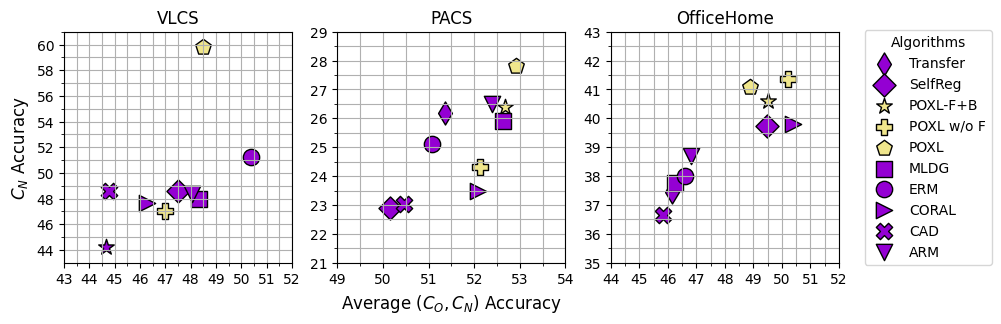

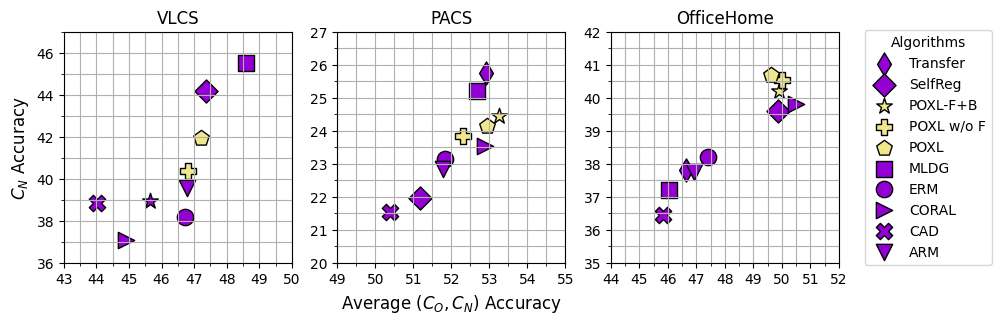

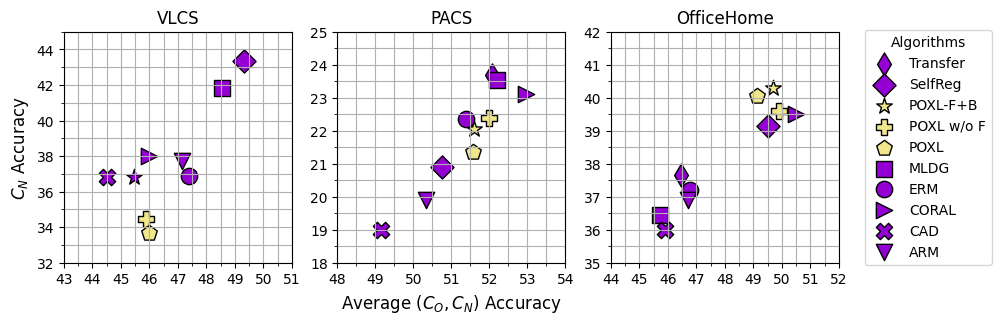

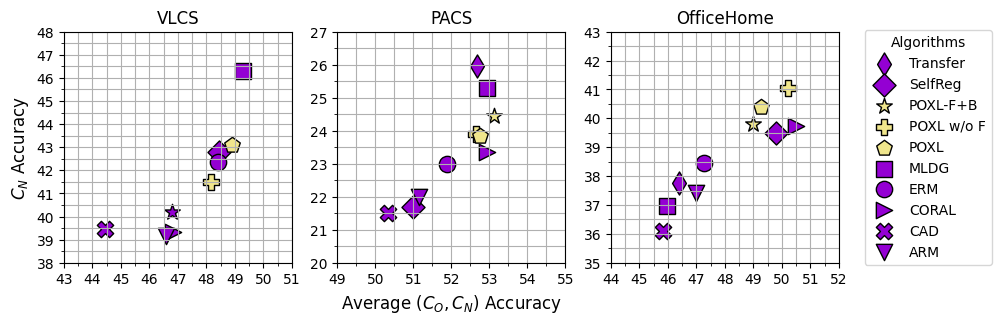

In [16]:
import math
from matplotlib.ticker import FormatStrFormatter

def get_dataset_metric(data, eval_metric, selec_metric, dataset):
    """Averaging across overlaps for a specific dataset"""
    #print(f"({selec_metric}, {eval_metric}, {dataset})")
    data = df.loc[
        (df['dataset'] == dataset) &
        (df['selection_metric'] == selec_metric) &  
        (df['evaluation_metric'] == eval_metric) &
        ((df['overlap'] == '66') | (df['overlap'] == '33')) &
        (df['algorithm'] != 'XDomBatch') &
#         (df['algorithm'] != 'XDom') &
#         (df['algorithm'] != 'XDomError') &
        (df['algorithm'] != 'SupCon') &
        (df['algorithm'] != 'Intra') &
        (df['algorithm'] != 'Intra_XDom')
    ].sort_values(by='algorithm', ascending=True).reset_index(drop=True)
    
    cols = ['algorithm', 'overlap', 'dataset', 'evaluation_value']
    metric_data = data.groupby('algorithm').mean(numeric_only=True).reset_index(names="algorithm")
    return metric_data

def plot_dataset(
    df, dataset, ax, color_metric, selec_metric, x, y
    ):
    """Plot average across overlaps for each dataset"""
    num_major_ticks = 7
    algorithm=get_dataset_metric(df, 'oacc', selec_metric, dataset)['algorithm']
    df_oacc = get_dataset_metric(df, 'oacc', selec_metric, dataset)['evaluation_value']
    df_nacc = get_dataset_metric(df, 'nacc', selec_metric, dataset)['evaluation_value']
    df_acc = get_dataset_metric(df, 'acc', selec_metric, dataset)['evaluation_value']
    df_f1 = get_dataset_metric(df, 'f1', selec_metric, dataset)['evaluation_value']
    df_diff = df_oacc - df_nacc
    df_ave_acc = (df_oacc+df_nacc)/2
    assert len(df_oacc) == len(df_nacc) == len(df_acc) == len(algorithm)
    
    markers = ['v','X','>', 'o','s','p', 'P', '*', 'D', 'd']
    assert len(markers) >= len(algorithm)

    # dataframe 
    data = pd.DataFrame(data={
        'marker': markers[:len(algorithm)],
        'algorithm': algorithm,
        'nacc': df_nacc,
        'oacc': df_oacc,
        'acc': df_acc,
        'av_acc': df_ave_acc,
        'f1': df_f1,
        'diff': df_diff,
    }).sort_values(by='algorithm', ascending=False).reset_index(drop=True)
    #print(data)
    
    # colour mapping
    my_cmap = plt.get_cmap("viridis")
    def rescale(row, rows):
        return (row - np.min(rows)) / (np.max(rows) - np.min(rows))
    
    # populate scatter plot
    for index, row in data.iterrows():
        if "POXL" in row['algorithm']:
            color = "khaki"
        else:
            color = "darkviolet"
        s=ax.scatter(
            x=row[x],
            y=row[y],
            #color=my_cmap(rescale(row[color_metric], data[color_metric])),
            color=color,
            edgecolor='black',
            label=row['algorithm'],
            marker=row['marker'],
            s=mpl.rcParams['lines.markersize'] ** 2.75
        )
        
    # AXIS LABELS
    # ax.set_title(f"{dataset}-{selec_metric}")
    ax.set_title(f"{dataset}")
    ax.grid(axis="both", which="both")
    # AXIS RANGE/VALUES
    # AXIS X
    x_min = math.floor(min(data[x]))-1
    x_max = math.ceil(max(data[x]))+1
    x_steps = (x_max - x_min)/num_major_ticks
    ax.set_xlim(x_min, x_max)
    ax.set_xticks(np.arange(x_min, x_max, x_steps))
    # AXIS Y
    y_min = math.floor(min(data[y]))-1
    y_max = math.ceil(max(data[y]))+1
    y_steps = (y_max - y_min)/num_major_ticks
    ax.set_ylim(y_min, y_max)
    ax.set_yticks(np.arange(y_min, y_max, y_steps))

    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    
    ax.get_yaxis().set_major_locator(MaxNLocator(integer=True))
    ax.get_xaxis().set_major_locator(MaxNLocator(integer=True))
    
    return ax

dataset_list = list(df['dataset'].unique())
x='av_acc'
y='nacc'
color_metric='acc'
labels = {
    "nacc": r"$C_{N}$ Accuracy",
    "oacc": r"$C_{O}$ Accuracy",
    "av_acc": r"Average ($C_{O},C_{N}$) Accuracy",
}

for selec_metric in ['nacc', 'acc', 'oacc', 'f1']:
    fig, ax = plt.subplots(
        nrows=1, ncols=len(dataset_list), figsize=(10,3), sharey=False)

    for i, dataset in enumerate(dataset_list):
        last_ax = plot_dataset(
            df, 
            dataset, 
            ax[i], 
            selec_metric=selec_metric,
            x=x,
            y=y,
            color_metric=color_metric)

    # LABELS
    ax[0].set_ylabel(labels[y], fontsize=12)
    ax[1].set_xlabel(labels[x], fontsize=12)
    # LEGEND
    ax[-1].legend(loc='center right', bbox_to_anchor=(1.7, 0.5), title="Algorithms")

    fig.show()

## Create a scatter plot for each dataset for each overlap
- Also visualizes the effect of different selection metrics

/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_68125/2437309611.py:127: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_68125/2437309611.py:127: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


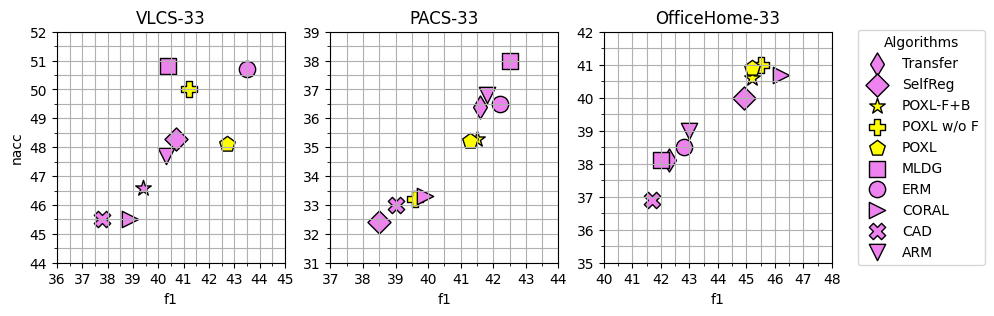

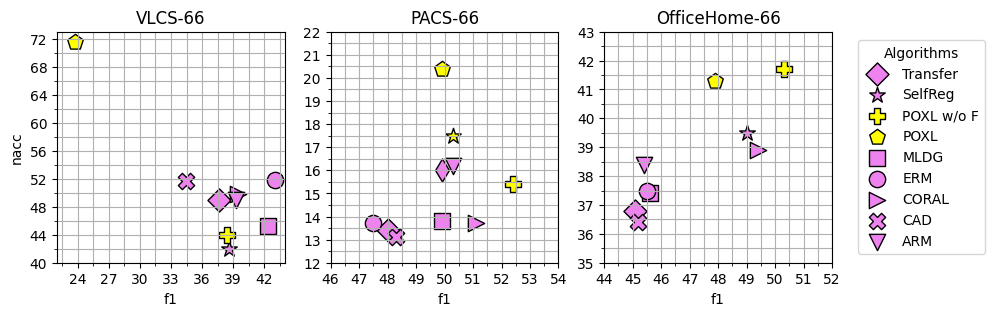

In [19]:
import math
from matplotlib.ticker import FormatStrFormatter

def get_dataset_metric(data, eval_metric, selec_metric, dataset, overlap):
    """Averaging across overlaps for a specific dataset"""
    #print(f"({selec_metric}, {eval_metric}, {dataset})")
    data = df.loc[
        (df['dataset'] == dataset) &
        (df['selection_metric'] == selec_metric) &  
        (df['evaluation_metric'] == eval_metric) &
        (df['overlap'] == overlap) &
        (df['algorithm'] != 'XDomBatch') &
#         (df['algorithm'] != 'XDom') &
#         (df['algorithm'] != 'XDomError') &
        (df['algorithm'] != 'SupCon') &
        (df['algorithm'] != 'Intra') &
        (df['algorithm'] != 'Intra_XDom')
    ].sort_values(by='algorithm', ascending=True).reset_index(drop=True)
    
    cols = ['algorithm', 'overlap', 'dataset', 'evaluation_value']
    metric_data = data.groupby('algorithm').mean(numeric_only=True).reset_index(names="algorithm")
    return metric_data

def plot_dataset(
    df, dataset, ax, color_metric, selec_metric, x, y, overlap
    ):
    """Plot average across overlaps for each dataset"""
    num_major_ticks = 7
    algorithm=get_dataset_metric(df, 'oacc', selec_metric, dataset, overlap)['algorithm']
    df_oacc = get_dataset_metric(df, 'oacc', selec_metric, dataset, overlap)['evaluation_value']
    df_nacc = get_dataset_metric(df, 'nacc', selec_metric, dataset, overlap)['evaluation_value']
    df_acc = get_dataset_metric(df, 'acc', selec_metric, dataset, overlap)['evaluation_value']
    df_f1 = get_dataset_metric(df, 'f1', selec_metric, dataset, overlap)['evaluation_value']
    df_diff = df_oacc - df_nacc
    df_ave_acc = (df_oacc+df_nacc)/2
    assert len(df_oacc) == len(df_nacc) == len(df_acc) == len(algorithm)
    
    markers = ['v','X','>', 'o','s','p', 'P', '*', 'D', 'd']
    assert len(markers) >= len(algorithm)

    # dataframe 
    data = pd.DataFrame(data={
        'marker': markers[:len(algorithm)],
        'algorithm': algorithm,
        'nacc': df_nacc,
        'oacc': df_oacc,
        'acc': df_acc,
        'av_acc': df_ave_acc,
        'f1': df_f1,
        'diff': df_diff,
    }).sort_values(by='algorithm', ascending=False).reset_index(drop=True)
    #print(data)
    
    # colour mapping
    my_cmap = plt.get_cmap("viridis")
    def rescale(row, rows):
        return (row - np.min(rows)) / (np.max(rows) - np.min(rows))
    
    # populate scatter plot
    for index, row in data.iterrows():
        if "POXL" in row['algorithm']:
            color = "yellow"
        else:
            color = "violet"
        s=ax.scatter(
            x=row[x],
            y=row[y],
            #color=my_cmap(rescale(row[color_metric], data[color_metric])),
            color=color,
            edgecolor='black',
            label=row['algorithm'],
            marker=row['marker'],
            s=mpl.rcParams['lines.markersize'] ** 2.75
        )
    # AXIS LABELS
    ax.set_title(f"{dataset}-{overlap}")
    ax.set_xlabel(x)
    #ax.set_ylabel("Overlapping class accuracy")
    ax.grid(axis="both", which="both")
    # AXIS RANGE/VALUES
    # AXIS X
    x_min = math.floor(min(data[x]))-1
    x_max = math.ceil(max(data[x]))+1
    x_steps = (x_max - x_min)/num_major_ticks
    ax.set_xlim(x_min, x_max)
    ax.set_xticks(np.arange(x_min, x_max, x_steps))
    # AXIS Y
    y_min = math.floor(min(data[y]))-1
    y_max = math.ceil(max(data[y]))+1
    y_steps = (y_max - y_min)/num_major_ticks
    ax.set_ylim(y_min, y_max)
    ax.set_yticks(np.arange(y_min, y_max, y_steps))

    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    
    ax.get_yaxis().set_major_locator(MaxNLocator(integer=True))
    ax.get_xaxis().set_major_locator(MaxNLocator(integer=True))
    
    return ax

dataset_list = list(df['dataset'].unique())
x='f1'
y='nacc'
color_metric='acc'
selec_metric='nacc'

for overlap in ['33', '66']:
    fig, ax = plt.subplots(
        nrows=1, ncols=len(dataset_list), figsize=(10,3), sharey=False)

    for i, dataset in enumerate(dataset_list):
        last_ax = plot_dataset(
            df, 
            dataset, 
            ax[i], 
            selec_metric=selec_metric,
            x=x,
            y=y,
            color_metric=color_metric,
            overlap=overlap)

    ax[0].set_ylabel(y)
    # LEGEND
    ax[-1].legend(loc='center right', bbox_to_anchor=(1.7, 0.5), title="Algorithms")

    fig.show()